# Kaggle Challenge : Give Me Some Credit


<div style="padding-top:2em;">
<div class="row">
<div class="col col-sm-4">
<img src="https://kaggle2.blob.core.windows.net/competitions/kaggle/2551/logos/front_page.png" style="width:200px;height:100px;">
</div>
<div class="col col-sm-4">
Give Me Some Credit
Improve on the state of the art in credit scoring by predicting the probability that somebody will experience financial distress in the next two years.
</div>
</div>

Banks play a crucial role in market economies. They decide who can get finance and on what terms and can make or break investment decisions. For markets and society to function, individuals and companies need access to credit. 

Credit scoring algorithms, which make a guess at the probability of default, are the method banks use to determine whether or not a loan should be granted. This competition requires participants to improve on the state of the art in credit scoring, by predicting the probability that somebody will experience financial distress in the next two years.

The goal of this competition is to build a model that borrowers can use to help make the best financial decisions.

Historical data are provided on 250,000 borrowers and 
the prize pool is 5,000 

* 3,000 for first, 
* 1,500 for second and 
* 500 for third.

## Methods

I'm going to implement a ensemble classifier using a couple of methods:

* xgboost
* Random Forest 
* SVM
* PCA
* Artificial Neural Networks

## Scoring Metric: Area Under the Curve (AUC)

Evaluation is done us the AUC or Receiver operating characteristic (ROC), sometimes also referred collectively as 
 Area Under the Receiver Operating Characteristic curve.
 

Y-axis is True Positive Rate (TPR) / Sensitivity
X-axis is the False Positive Rate (FPR) / 1 - specificity

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/Sensitivity_and_specificity.svg/700px-Sensitivity_and_specificity.svg.png"  style="height:400px; width:200px">
<caption><center> **ROC AUC**</center></caption><br>

TPR = True positives / Positives 
Positives = True Positives + False Negativs

FPR = False Positives / Negatives
Negatives = True Negatives + False Positives

<img src="http://mchp-appserv.cpe.umanitoba.ca/concept/roc_gif_small.gif">
<caption><center> **Figure 1**</center></caption><br>

Thus having a high AUC curve will be to have a high sensitivity while keeping the false positive rate low

Besides AUC/ROC there's also log

In [1]:
#now lets import the universe
import os

import pandas as pd
import numpy as np 

import rpy2
%load_ext rpy2.ipython
# use R's ggplot to plot instead
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook

#machine learning
## xgboost
import xgboost as xgb
from xgboost import XGBClassifier
## sklearn
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion     #
from sklearn_pandas import DataFrameMapper    #
from sklearn_pandas import CategoricalImputer #
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Imputer
#score
from sklearn.metrics import roc_auc_score
import subprocess
%connect_info

{
  "shell_port": 55081,
  "iopub_port": 37545,
  "stdin_port": 54775,
  "control_port": 57821,
  "hb_port": 47011,
  "ip": "127.0.0.1",
  "key": "3ea35af3-098a30e988797ba1808f6dff",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-965aa04e-a529-4665-a3e3-640c5ab3a41c.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


# Input data

Below's the description of the input data:

| Variable Name | Description | Type |
| --- | --- | --- |
| SeriousDlqin2yrs  | Person experienced 90 days past due delinquency or worse |  Y/N |
| RevolvingUtilizationOfUnsecuredLines  | Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits  | percentage | 
| age | Age of borrower in years  | integer |
| NumberOfTime30-59DaysPastDueNotWorse  | Number of times borrower has been 30-59 days past due but no worse in the last 2 years. | integer |
| DebtRatio | Monthly debt payments, alimony,living costs divided by monthy gross income | percentage |
| MonthlyIncome | Monthly income  | real |
| NumberOfOpenCreditLinesAndLoans | Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards)  | integer |
| NumberOfTimes90DaysLate | Number of times borrower has been 90 days or more past due. | integer |
| NumberRealEstateLoansOrLines  | Number of mortgage and real estate loans including home equity lines of credit  | integer| 
| NumberOfTime60-89DaysPastDueNotWorse  | Number of times borrower has been 60-89 days past due but no worse in the last 2 years. | integer | 
| NumberOfDependents |  Number of dependents in family excluding themselves (spouse, children etc.) | integer | 

# Exploratory Analysis

## 1. Class imbalance 

In [4]:
X_train, X_test, y_train, y_test, testDF = loadData(preprocessed=False)
defaulted = np.sum(y_train != 0) + np.sum(y_test != 0)
clean = np.sum(y_train == 0) + np.sum(y_test == 0)

classSep = pd.DataFrame({
    "class":["defaulted","clean"],
    "value":[defaulted, clean]
}, index=[0,1])
classSep

,class,value
0,defaulted,10026
1,clean,139974


In [5]:
weights = np.array(classSep['value']/np.sum(classSep['value']))
classweight = {1:weights[0], 0:weights[1]}
classweight

{0: 0.93316, 1: 0.06684}

/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Warning:
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  Ignoring unknown parameters: binwidth, bins, pad

  warnings.warn(x, RRuntimeWarning)


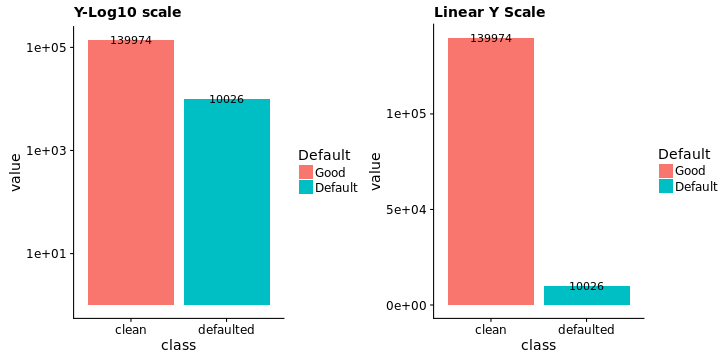

In [6]:
%%R -i classSep -w 10 -h 5 -u in

suppressPackageStartupMessages({
    library(tidyverse)
    library(cowplot)
})

suppressMessages({
    p1 = ggplot(classSep, aes(class, value, fill=class))+ 
        geom_histogram(stat="identity") +
        geom_text(aes(y=value, label=value)) + 
        scale_fill_discrete("Default", labels=c("Good", "Default")) +
        scale_y_log10() + ggtitle("Y-Log10 scale")
     p2 = ggplot(classSep, aes(class, value, fill=class))+ 
        geom_histogram(stat="identity") +
        geom_text(aes(y=value, label=value)) + 
        scale_fill_discrete("Default", labels=c("Good", "Default")) + ggtitle("Linear Y Scale")
    p = plot_grid(p1, p2, nrow=1) 
        })   
print(p)

In [ ]:
%%R -i X_train 

suppressWarnings({ 
        library(tidyverse)
        library(GGally)
        ggpairs(X_train) %>% ggsave(filename="ggpairs.png", w=30, h=30, dpi=300) 
})

<img src="./ggpairs.png">
<caption><center> **Figure 2**: Pairs plot</center></caption><br>

In [15]:
X_train, X_test, y_train, y_test, testDF = loadData(logTransform=True, preprocessed=False)

In [ ]:
%%R -i X_train 

suppressWarnings({ 
        library(tidyverse)
        library(GGally)
        X_train %>% select(-DebtRatio, -NumberOfTime30.59DaysPastDueNotWorse, -MonthlyIncome, 
                                    -NumberOfOpenCreditLinesAndLoans, -NumberOfTimes90DaysLate, 
                                    -NumberRealEstateLoansOrLines, -NumberOfTime60.89DaysPastDueNotWorse) %>% 
        ggpairs() %>%
        ggsave(filename="ggpairslog.png", w=30, h=30, dpi=300) 
})

<img src="./ggpairslog.png">
<caption><center> **Figure 2**: Pairs plot</center></caption><br>

# Model2: XGB

Now that we know the logistic regression's error rate lets try a few more models

## Log columns 

In [80]:
#with log columns
X_train, X_test, y_train, y_test, testDF = loadData(logTransform=True, 
                                                    impute=False, 
                                                    preprocessed=False)
X_train.columns

Index(['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'NumberOfTime30-59DaysPastDueNotWorse-log',
       'MonthlyIncome-log', 'NumberOfOpenCreditLinesAndLoans-log',
       'NumberOfTimes90DaysLate-log', 'NumberRealEstateLoansOrLines-log',
       'NumberOfTime60-89DaysPastDueNotWorse-log'],
      dtype='object')

In [81]:
#sanity check
np.sum(y_train)/len(y_train), np.sum(y_test)/len(y_test)

(0.06684166666666666, 0.06683333333333333)

In [79]:
X_train.head()

,UnknownNumberOfDependents,UnknownMonthlyIncome,NoDependents,NoIncome,ZeroDebtRatio,UnknownIncomeDebtRatio,WeirdRevolvingUtilization,ZeroRevolvingUtilization,Log.Debt,RevolvingLines,...,Log.DebtPer90DaysLate,Log.UnknownIncomeDebtRatio,Log.UnknownIncomeDebtRatioPerPerson,Log.UnknownIncomeDebtRatioPerLine,Log.UnknownIncomeDebtRatioPerRealEstateLine,Log.UnknownIncomeDebtRatioPerDelinquency,Log.UnknownIncomeDebtRatioPer90DaysLate,Log.NumberRealEstateLoansOrLines,LowAge,Log.age
X,,,,,,,,,,,,,,,,,,,,,
146722,0,0,0,0,0,0,0.0,0,5.774363,9,...,5.774363,0.0,-0.693147,-2.302585,0.000000,-0.693147,0.0,0.0,0,3.663562
148883,0,0,0,0,0,0,0.0,0,6.379823,5,...,6.379823,0.0,-0.693147,-1.791759,0.000000,0.000000,0.0,0.0,0,3.044522
70887,0,0,0,0,0,0,0.0,0,8.153519,7,...,8.153519,0.0,-1.098612,-2.197225,-0.693147,-0.693147,0.0,0.0,0,3.218876
33053,0,0,0,0,0,0,0.0,0,7.130626,10,...,7.130626,0.0,-0.693147,-2.397895,0.000000,-1.098612,0.0,0.0,0,2.833213
96451,0,0,0,0,0,0,0.0,0,6.841323,7,...,6.841323,0.0,-0.693147,-2.079442,0.000000,0.000000,0.0,0.0,0,4.442651


In [14]:
# Standardised sklearn pipeline with XGB

# Create a boolean mask for categorical columns
# Dont really need cause none of the columns are objects but lets just keep it 
categorical_feature_mask = X_train.dtypes == object

# Get list of categorical column names
categorical_columns = X_train.columns[categorical_feature_mask].tolist()

# Get list of non-categorical column names
non_categorical_columns = X_train.columns[~categorical_feature_mask].tolist()

# Apply numeric imputer (using median/mean) both gives almost the same value
# aka fill the NaNs
numeric_imputation_mapper = DataFrameMapper(
   [([numeric_feature], Imputer(strategy="median")) for numeric_feature in non_categorical_columns],
   input_df=True,
   df_out=True
)

categorical_imputation_mapper = DataFrameMapper(
    [(category_feature, Categorical()) for category_feature in categorical_columns],
    input_df=True,
    df_out=True
)

# Combine the numeric and categorical transformations
numeric_categorical_union = FeatureUnion([
    ("num_mapper", numeric_imputation_mapper),
    ("cat_mapper", categorical_imputation_mapper)
])

#param['tree_method'] = 'gpu_hist'

params = { 
        "n_estimators": 400, 
        'tree_method':['gpu_hist'], 
        'predictor':['gpu_predictor'] 
         }

# Create full pipeline
#pipeline = Pipeline([
#   ("featureunion", numeric_imputation_mapper),
#   ("clf", xgb.XGBClassifier(max_depth=3, scale_pos_weight=1)) #class imbalance
#])
weights = (y_train == 0).sum() / (1.0 * (y_train == 1).sum())
pipeline = Pipeline([
   ("featureunion", numeric_imputation_mapper),
   ("clf", xgb.XGBClassifier(max_depth=10, 
                         scale_pos_weight=weights, 
                             gamma=20
                            )) #class imbalance
])

# Perform cross-validation
#cross_val_scores_cpu = cross_val_score(pipeline, X_train, y_train, scoring="roc_auc", cv=3)

In [28]:
# Print avg. AUC
print("3-fold AUC: ", np.mean(cross_val_scores_cpu))

3-fold AUC:  0.8535582293495284


In [29]:
model = pipeline.fit(X_train, y_train)

In [30]:
#model = pipeline.fit(X_train, y_train)
dev = model.predict(X_test)
roc_auc_score(dev, y_test)

/home/uesu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.6090251374978501

In [32]:
predsSubmit = model.predict(testDF)
submit(preds, "xgb_straitified_processing_weights_gamma.csv", "xgb stratified preprocessing weights gamma")

/home/uesu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [51]:
# Standardised sklearn pipeline with XGB

# Create a boolean mask for categorical columns
# Dont really need cause none of the columns are objects but lets just keep it 
categorical_feature_mask = X_train.dtypes == object

# Get list of categorical column names
categorical_columns = X_train.columns[categorical_feature_mask].tolist()

# Get list of non-categorical column names
non_categorical_columns = X_train.columns[~categorical_feature_mask].tolist()

# Apply numeric imputer (using median/mean) both gives almost the same value
# aka fill the NaNs
numeric_imputation_mapper = DataFrameMapper(
   [([numeric_feature], Imputer(strategy="median")) for numeric_feature in non_categorical_columns],
   input_df=True,
   df_out=True
)

categorical_imputation_mapper = DataFrameMapper(
    [(category_feature, Categorical()) for category_feature in categorical_columns],
    input_df=True,
    df_out=True
)

# Combine the numeric and categorical transformations
numeric_categorical_union = FeatureUnion([
    ("num_mapper", numeric_imputation_mapper),
    ("cat_mapper", categorical_imputation_mapper)
])

#tried running with GPU (nope doesnt work)
#param['tree_method'] = 'gpu_hist'
params = { 
        "n_estimators": 400, 
        'tree_method':['gpu_hist'], 
        'predictor':['gpu_predictor'] 
         }

# Create full pipeline
#pipeline = Pipeline([
#   ("featureunion", numeric_imputation_mapper),
#   ("clf", xgb.XGBClassifier(max_depth=3, scale_pos_weight=1)) #class imbalance
#])
weights = (y_train == 0).sum() / (1.0 * (y_train == 1).sum())
pipeline = Pipeline([
   ("featureunion", numeric_imputation_mapper),
   ("clf", xgb.XGBClassifier(max_depth=10, 
                         scale_pos_weight=weights, 
                             gamma=20
                            )) #class imbalance
])

# Perform cross-validation
#cross_val_scores_cpu = cross_val_score(pipeline, X_train, y_train, scoring="roc_auc", cv=3)

In [28]:
# Print avg. AUC
print("3-fold AUC: ", np.mean(cross_val_scores_cpu))

3-fold AUC:  0.8535582293495284


In [29]:
model = pipeline.fit(X_train, y_train)

In [30]:
#model = pipeline.fit(X_train, y_train)
dev = model.predict(X_test)
roc_auc_score(dev, y_test)

/home/uesu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.6090251374978501

In [32]:
predsSubmit = model.predict(testDF)
submit(preds, "xgb_straitified_processing_weights_gamma.csv", "xgb stratified preprocessing weights gamma")

/home/uesu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Amazing!!!

Adding the weights, and the gamma set to damn high 20, my public and private rose

0.775060, 0.769128

Tuning, we could do either one of two 

1. Randomised Search
2. Grid Search

In [52]:
gbm_param_grid = {
        'clf__learning_rate': np.arange(0.05, 1, 0.05),
            'clf__max_depth': np.arange(3, 10, 1),
        'clf__n_estimators': np.arange(50, 200, 50)#,
        #'clf__gamma':[5,10,13,16,19,20]
}

# Perform RandomizedSearchCV
grid_roc_auc = GridSearchCV(pipeline,
    param_grid=gbm_param_grid,
    scoring="roc_auc",
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit the estimator
grid_roc_auc.fit(X_train, y_train)

# Compute metrics
print(f'my best score: {grid_roc_auc.best_score_}')
print(grid_roc_auc.best_estimator_)

Fitting 3 folds for each of 399 candidates, totalling 1197 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 1197 out of 1197 | elapsed: 15.3min finished


my best score: 0.8649865004930518
Pipeline(memory=None,
     steps=[('featureunion', DataFrameMapper(default=False, df_out=True,
        features=[(['RevolvingUtilizationOfUnsecuredLines'], Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), (['age'], Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)),...=0, reg_lambda=1, scale_pos_weight=13.960728088766986,
       seed=None, silent=True, subsample=1))])


In [76]:
preds = grid_roc_auc.predict(X_test)
accuracy = float(np.sum(preds==y_test)/y_test.shape[0] )
print(f'Accuracy: {accuracy}')
print(f'AUC: {roc_auc_score(preds, y_test)}')

Accuracy: 0.7973666666666667
AUC: 0.598183473983141


/home/uesu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Interesting with the gamma turned on the AUC is bad

In [56]:
preds = grid_roc_auc.predict(testDF)

/home/uesu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [57]:
#predsSubmit = model.predict(testDF)
submit(preds, "xgb_straitified_processing_weights_gamma_gridsearch2.csv", "xgb stratified preprocessing weights gamma grid2")

/home/uesu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [59]:
grid_roc_auc.best_estimator_.named_steps['clf']

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=20, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=150,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=13.960728088766986,
       seed=None, silent=True, subsample=1)

with the grid search

| public | private |  
| --- | --- | 
| 0.790252 0.783193 | 

# Random Forest

In [112]:
from sklearn.ensemble import RandomForestClassifier


rf_pipeline = Pipeline([
   ("featureunion", numeric_imputation_mapper),
   ("rf",RandomForestClassifier(random_state=123, n_jobs=-1, class_weight=classweight, n_estimators=600))
])

# Perform cross-validation
cross_val_scores = cross_val_score(rf_pipeline, X_train, y_train, scoring="roc_auc", cv=10)
model = pipeline.fit(X_train, y_train)
    
dev = model.predict(X_test)
testScore = roc_auc_score(dev, y_test)
    
print("3-fold AUC: ", np.mean(cross_val_scores))
print("test AUC: ", testScore)

3-fold AUC:  0.845359180700734
test AUC:  0.6090251374978501


/home/uesu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [113]:
rfPreds = model.predict(testDF)
#nestimators 500 or 400 gets the same score
submit(rfPreds, "rf_500.csv", "rf 500")

/home/uesu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


RF is doing quite similarly with XGB, the private, public LB is: 0.775060, 0.769128 compared with XGB's 0.790252, 0.783193 but with lesser tunning for hyperparameters required.

## Stacking / ensembling


tried stacking with a metaclassifier (linear regression) doesnt work its, worse. 
tried ensembling (vote) better but the score is still worse than individual predictor. 

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from mlxtend.classifier import StackingClassifier
from mlxtend.classifier import EnsembleVoteClassifier

X_train, X_test, y_train, y_test, testDF = loadData(
    logTransform=True, 
    impute=False, 
    preprocessed=False, 
    continuous=False
)

from sklearn.pipeline import make_pipeline

pipe1 = make_pipeline(numeric_imputation_mapper,
                      XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=20, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=150,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=13.960728088766986,
       seed=None, silent=True, subsample=1))

pipe2 = make_pipeline(numeric_imputation_mapper,
                      RandomForestClassifier(max_depth=None, random_state=123, class_weight=classweight, n_estimators=400)
                      )


# Initializing models
#clf1 = KNeighborsClassifier(n_neighbors=1)
#using the gridSearch version
#clf2 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#       colsample_bytree=1, gamma=20, learning_rate=0.1, max_delta_step=0,
#       max_depth=3, min_child_weight=1, missing=None, n_estimators=150,
#       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
#       reg_alpha=0, reg_lambda=1, scale_pos_weight=13.960728088766986,
#       seed=None, silent=True, subsample=1)
#clf1 = RandomForestClassifier(max_depth=None, random_state=123, class_weight=classweight, n_estimators=500)
#clf2 = XGBClassifier(max_depth=3, scale_pos_weight=1) #class imbalance
#clf3 = GaussianNB()
#clf3 = LogisticRegression()
eclf = EnsembleVoteClassifier(clfs=[pipe1, pipe2],
#eclf = EnsembleVoteClassifier(clfs=[clf1, clf2],
                              weights=[1, 1], voting='soft')
#sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
#                          meta_classifier=lr)

#params = {
#    'logisticregression__C':  [0.001, 0.01]
#}

#grid = GridSearchCV(estimator=sclf, 
#grid = GridSearchCV(estimator=eclf, 
#                    param_grid=params, 
#                    cv=5,
#                    n_jobs=-1,
#                    scoring='roc_auc',
#                    refit=True)
#X_train.head()
#newX = numeric_imputation_mapper.transform(X_train)
#grid.fit(X_train, y_train)
eclf.fit(X_train, y_train)

EnsembleVoteClassifier(clfs=[Pipeline(memory=None,
     steps=[('dataframemapper', DataFrameMapper(default=False, df_out=True,
        features=[(['RevolvingUtilizationOfUnsecuredLines'], Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), (['age'], Imputer(axis=0, copy=True, missing_values='N...ators=400, n_jobs=1, oob_score=False, random_state=123,
            verbose=0, warm_start=False))])],
            refit=True, verbose=0, voting='soft', weights=[1, 1])

In [31]:
#cv_keys = ('mean_test_score', 'std_test_score', 'params')
#for r, _ in enumerate(grid.cv_results_['mean_test_score']):
#    print("%0.3f +/- %0.2f %r"
#          % (grid.cv_results_[cv_keys[0]][r],
#             grid.cv_results_[cv_keys[1]][r] / 2.0,
#             grid.cv_results_[cv_keys[2]][r]))
#newXtest = numeric_imputation_mapper.transform(X_test)
#devstack = grid.predict(newXtest)
#testScore = roc_auc_score(devstack, y_test)
#newXtest = numeric_imputation_mapper.transform(X_test)
#devstack = grid.predict(X_test)
devstack = eclf.predict(X_test)
testScore = roc_auc_score(devstack, y_test)
#print('Best parameters: %s' % grid.best_params_)
print(f'test AUC: {testScore}')

test AUC: 0.680004518880724


/home/uesu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [33]:
#newXtest = numeric_imputation_mapper.transform(testDF)
#stackPreds = grid.predict(newXtest)
votePreds = eclf.predict(testDF)
submit(votePreds, "xgb_rf_voting2.csv", "xgb rf voting2")

/home/uesu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Adding RF and XGB brought the score down: private, public: 
        0.721574, 0.722799


## Single Layer perceptron

In [57]:
# Multilayer perceptron
import keras
from keras.models import Sequential
from keras.models import Model
#layers
from keras.layers import Dense, Dropout, Input
from keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier
#import tensorflow as tf
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [37]:
# fix random seed for reproducibility
np.random.seed(7)

# split into input (X) and output (Y) variables
X_train_matrix = X_train.as_matrix(columns=[X_train.columns[:]])
X_train_matrix[0,:]

array([ 4.98037042e-01,  5.60000000e+01,  1.00000000e+00,  6.05718590e-02,
        5.31500000e+03,  9.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.00000000e+00,  4.34294477e-09,  3.72550327e+00,
        9.54242510e-01, -8.00000000e+00, -8.00000000e+00, -8.00000000e+00])

In [39]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weight

array([0.53581475, 7.48036404])

In [62]:
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(60, input_dim=16, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=2000, verbose=1)
kfold = StratifiedKFold(y_train.values, n_folds=5, shuffle=True, random_state=123)
results = cross_val_score(estimator, X_train_matrix, y_train.values, cv=kfold)

Epoch 1/100
107999/107999 [==============================] - 1s 5us/step - loss: 0.6895 - acc: 0.9332
Epoch 2/100
107999/107999 [==============================] - 0s 3us/step - loss: 0.6593 - acc: 0.9332
Epoch 3/100
107999/107999 [==============================] - 0s 3us/step - loss: 0.6377 - acc: 0.9332
Epoch 4/100
107999/107999 [==============================] - 0s 3us/step - loss: 0.6172 - acc: 0.9332
Epoch 5/100
107999/107999 [==============================] - 0s 3us/step - loss: 0.5977 - acc: 0.9332
Epoch 6/100
107999/107999 [==============================] - 0s 3us/step - loss: 0.5792 - acc: 0.9332
Epoch 7/100
107999/107999 [==============================] - 0s 3us/step - loss: 0.5616 - acc: 0.9332
Epoch 8/100
107999/107999 [==============================] - 2s 16us/step - loss: 0.5449 - acc: 0.9332
Epoch 9/100
107999/107999 [==============================] - 0s 3us/step - loss: 0.5291 - acc: 0.9332A: 0s - loss: 0.5346 - acc: 0
Epoch 10/100
107999/107999 [========================

107999/107999 [==============================] - 0s 3us/step - loss: 0.2475 - acc: 0.9332
Epoch 81/100
107999/107999 [==============================] - 0s 3us/step - loss: 0.2473 - acc: 0.9332
Epoch 82/100
107999/107999 [==============================] - 0s 3us/step - loss: 0.2471 - acc: 0.9332
Epoch 83/100
107999/107999 [==============================] - 0s 3us/step - loss: 0.2469 - acc: 0.9332
Epoch 84/100
107999/107999 [==============================] - 0s 3us/step - loss: 0.2467 - acc: 0.9332
Epoch 85/100
107999/107999 [==============================] - 0s 3us/step - loss: 0.2466 - acc: 0.9332
Epoch 86/100
107999/107999 [==============================] - 0s 3us/step - loss: 0.2465 - acc: 0.9332
Epoch 87/100
107999/107999 [==============================] - 0s 3us/step - loss: 0.2463 - acc: 0.9332
Epoch 88/100
107999/107999 [==============================] - 0s 3us/step - loss: 0.2462 - acc: 0.9332
Epoch 89/100
107999/107999 [==============================] - 0s 3us/step - loss: 0.24

108000/108000 [==============================] - 0s 3us/step - loss: 0.2586 - acc: 0.9332
Epoch 60/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2577 - acc: 0.9332
Epoch 61/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2568 - acc: 0.9332
Epoch 62/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2559 - acc: 0.9332
Epoch 63/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2552 - acc: 0.9332
Epoch 64/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2544 - acc: 0.9332
Epoch 65/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2537 - acc: 0.9332
Epoch 66/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2531 - acc: 0.9332
Epoch 67/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2525 - acc: 0.9332
Epoch 68/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.25

108000/108000 [==============================] - 0s 3us/step - loss: 0.2994 - acc: 0.9332
Epoch 39/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2962 - acc: 0.9332
Epoch 40/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2931 - acc: 0.9332
Epoch 41/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2903 - acc: 0.9332
Epoch 42/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2875 - acc: 0.9332
Epoch 43/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2850 - acc: 0.9332
Epoch 44/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2825 - acc: 0.9332
Epoch 45/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2802 - acc: 0.9332
Epoch 46/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2780 - acc: 0.9332
Epoch 47/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.27

108000/108000 [==============================] - 0s 3us/step - loss: 0.4279 - acc: 0.9332
Epoch 18/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.4179 - acc: 0.9332
Epoch 19/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.4085 - acc: 0.9332
Epoch 20/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.3996 - acc: 0.9332
Epoch 21/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.3912 - acc: 0.9332
Epoch 22/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.3832 - acc: 0.9332
Epoch 23/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.3756 - acc: 0.9332
Epoch 24/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.3684 - acc: 0.9332
Epoch 25/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.3616 - acc: 0.9332
Epoch 26/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.35

108000/108000 [==============================] - 0s 3us/step - loss: 0.2457 - acc: 0.9332
Epoch 97/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2457 - acc: 0.9332
Epoch 98/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2456 - acc: 0.9332
Epoch 99/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2456 - acc: 0.9332
Epoch 100/100
12000/12000 [==============================] - 0s 10us/step
Epoch 1/100
108000/108000 [==============================] - 1s 6us/step - loss: 0.8855 - acc: 0.9206
Epoch 2/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.6592 - acc: 0.9332
Epoch 3/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.6377 - acc: 0.9332
Epoch 4/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.6172 - acc: 0.9332
Epoch 5/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.5977 - acc: 0.9332
Epoch 6/100
10800

108000/108000 [==============================] - 0s 3us/step - loss: 0.2489 - acc: 0.9332
Epoch 76/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2486 - acc: 0.9332
Epoch 77/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2483 - acc: 0.9332
Epoch 78/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2480 - acc: 0.9332
Epoch 79/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2477 - acc: 0.9332
Epoch 80/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2475 - acc: 0.9332
Epoch 81/100
108000/108000 [==============================] - 2s 16us/step - loss: 0.2473 - acc: 0.9332
Epoch 82/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2471 - acc: 0.9332
Epoch 83/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2469 - acc: 0.9332
Epoch 84/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2

108000/108000 [==============================] - 0s 3us/step - loss: 0.2646 - acc: 0.9332
Epoch 55/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2633 - acc: 0.9332
Epoch 56/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2621 - acc: 0.9332
Epoch 57/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2609 - acc: 0.9332
Epoch 58/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2598 - acc: 0.9332
Epoch 59/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2588 - acc: 0.9332
Epoch 60/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2578 - acc: 0.9332
Epoch 61/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2569 - acc: 0.9332
Epoch 62/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2561 - acc: 0.9332
Epoch 63/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.25

108000/108000 [==============================] - 0s 3us/step - loss: 0.3183 - acc: 0.9332
Epoch 34/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.3141 - acc: 0.9332
Epoch 35/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.3101 - acc: 0.9332
Epoch 36/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.3064 - acc: 0.9332
Epoch 37/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.3028 - acc: 0.9332
Epoch 38/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2994 - acc: 0.9332
Epoch 39/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2962 - acc: 0.9332
Epoch 40/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2931 - acc: 0.9332
Epoch 41/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2903 - acc: 0.9332
Epoch 42/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.28

108000/108000 [==============================] - 0s 3us/step - loss: 0.4861 - acc: 0.9332
Epoch 13/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.4732 - acc: 0.9332
Epoch 14/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.4609 - acc: 0.9332
Epoch 15/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.4493 - acc: 0.9332
Epoch 16/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.4383 - acc: 0.9332
Epoch 17/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.4279 - acc: 0.9332
Epoch 18/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.4179 - acc: 0.9332
Epoch 19/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.4085 - acc: 0.9332
Epoch 20/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.3996 - acc: 0.9332
Epoch 21/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.39

108000/108000 [==============================] - 0s 3us/step - loss: 0.2460 - acc: 0.9332
Epoch 92/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2459 - acc: 0.9332
Epoch 93/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2459 - acc: 0.9332
Epoch 94/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2458 - acc: 0.9332
Epoch 95/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2457 - acc: 0.9332
Epoch 96/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2457 - acc: 0.9332
Epoch 97/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2457 - acc: 0.9332
Epoch 98/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2456 - acc: 0.9332
Epoch 99/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2456 - acc: 0.9332
Epoch 100/100
12000/12000 [==============================] - 0s 13us/step
Epoch 1/100


108000/108000 [==============================] - 0s 3us/step - loss: 0.2509 - acc: 0.9332
Epoch 71/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2505 - acc: 0.9332
Epoch 72/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2500 - acc: 0.9332
Epoch 73/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2496 - acc: 0.9332
Epoch 74/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2493 - acc: 0.9332
Epoch 75/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2489 - acc: 0.9332
Epoch 76/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2486 - acc: 0.9332
Epoch 77/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2483 - acc: 0.9332
Epoch 78/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.2480 - acc: 0.9332
Epoch 79/100
108000/108000 [==============================] - 0s 3us/step - loss: 0.24

108001/108001 [==============================] - 2s 16us/step - loss: 0.2730 - acc: 0.9332
Epoch 49/100
108001/108001 [==============================] - 0s 3us/step - loss: 0.2712 - acc: 0.9332
Epoch 50/100
108001/108001 [==============================] - 0s 3us/step - loss: 0.2695 - acc: 0.9332
Epoch 51/100
108001/108001 [==============================] - 0s 3us/step - loss: 0.2679 - acc: 0.9332
Epoch 52/100
108001/108001 [==============================] - 0s 3us/step - loss: 0.2663 - acc: 0.9332
Epoch 53/100
108001/108001 [==============================] - 0s 3us/step - loss: 0.2649 - acc: 0.9332
Epoch 54/100
108001/108001 [==============================] - 0s 3us/step - loss: 0.2636 - acc: 0.9332
Epoch 55/100
108001/108001 [==============================] - 0s 3us/step - loss: 0.2623 - acc: 0.9332
Epoch 56/100
108001/108001 [==============================] - 0s 3us/step - loss: 0.2611 - acc: 0.9332
Epoch 57/100
108001/108001 [==============================] - 0s 3us/step - loss: 0.2

In [63]:
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Results: 93.32% (0.00%)


In [66]:
estimator.fit(X_train_matrix, y_train)

Epoch 1/100
120000/120000 [==============================] - 1s 7us/step - loss: 0.8591 - acc: 0.9219
Epoch 2/100
120000/120000 [==============================] - 0s 3us/step - loss: 0.6555 - acc: 0.9332
Epoch 3/100
120000/120000 [==============================] - 0s 3us/step - loss: 0.6318 - acc: 0.9332
Epoch 4/100
120000/120000 [==============================] - 0s 3us/step - loss: 0.6095 - acc: 0.9332
Epoch 5/100
120000/120000 [==============================] - 0s 3us/step - loss: 0.5883 - acc: 0.9332
Epoch 6/100
120000/120000 [==============================] - 0s 3us/step - loss: 0.5683 - acc: 0.9332
Epoch 7/100
120000/120000 [==============================] - 0s 3us/step - loss: 0.5494 - acc: 0.9332
Epoch 8/100
120000/120000 [==============================] - 0s 3us/step - loss: 0.5316 - acc: 0.9332
Epoch 9/100
120000/120000 [==============================] - 0s 3us/step - loss: 0.5148 - acc: 0.9332
Epoch 10/100
120000/120000 [==============================] - 0s 3us/step - loss: 

120000/120000 [==============================] - 0s 3us/step - loss: 0.2462 - acc: 0.9332
Epoch 81/100
120000/120000 [==============================] - 0s 3us/step - loss: 0.2461 - acc: 0.9332
Epoch 82/100
120000/120000 [==============================] - 0s 3us/step - loss: 0.2460 - acc: 0.9332
Epoch 83/100
120000/120000 [==============================] - 0s 3us/step - loss: 0.2459 - acc: 0.9332
Epoch 84/100
120000/120000 [==============================] - 0s 3us/step - loss: 0.2458 - acc: 0.9332
Epoch 85/100
120000/120000 [==============================] - 0s 3us/step - loss: 0.2458 - acc: 0.9332
Epoch 86/100
120000/120000 [==============================] - 0s 3us/step - loss: 0.2457 - acc: 0.9332
Epoch 87/100
120000/120000 [==============================] - 0s 3us/step - loss: 0.2457 - acc: 0.9332
Epoch 88/100
120000/120000 [==============================] - 0s 3us/step - loss: 0.2456 - acc: 0.9332
Epoch 89/100
120000/120000 [==============================] - 0s 3us/step - loss: 0.24

NameError: name 'singleLayer' is not defined

In [69]:
estimatorLayer = estimator.predict(X_test_matrix)
accuracy = float(np.sum(estimatorLayer.flatten() == y_test)/y_test.shape[0])
np.unique(estimatorLayer.flatten())

30000/30000 [==============================] - 0s 1us/step


array([0])

Severely overfitting, time to do some feature engineering and ensembling

# Multilayer perceptron

In [48]:
from keras.callbacks import EarlyStopping
from sklearn.cross_validation import StratifiedKFold
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

#def create_model():
    # create model
model = Sequential()
model.add(Dense(128, input_shape=(16,), activation='relu'))
model.add(Dropout(0.5))
#model.add(Dense(256, activation='relu', activity_regularizer=regularizers.l1(10e-5)))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
#model.add(Dense(32, activation='relu', activity_regularizer=regularizers.l1(10e-5)))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid')) #output
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

nb_epoch = 100
batch_size = 2000

#def train_and_evaluate__model(model, data, label, data_test, label_test):

model.fit(
        X_train_matrix, y_train.values, validation_split=0.1, 
        #callbacks=[early_stopping],
        class_weight=[0.5, 100], 
        epochs = nb_epoch,
        batch_size = batch_size
)
# skf = StratifiedKFold(y_train, n_folds=10, shuffle=True)
# for i, (train, test) in enumerate(skf):
#     print "Running Fold", i+1, "/", n_folds
#     model = None # Clearing the NN.
#     model = create_model()
#     train_and_evaluate_model(model, X_train[train], y_train[train], X_test[test], y_test[test))

Train on 108000 samples, validate on 12000 samples
Epoch 1/100
108000/108000 [==============================] - 1s 9us/step - loss: 0.4886 - acc: 0.9332 - val_loss: 0.2595 - val_acc: 0.9317
Epoch 2/100
108000/108000 [==============================] - 0s 4us/step - loss: 0.2512 - acc: 0.9333 - val_loss: 0.2493 - val_acc: 0.9317
Epoch 3/100
108000/108000 [==============================] - 0s 4us/step - loss: 0.2505 - acc: 0.9333 - val_loss: 0.2494 - val_acc: 0.9317
Epoch 4/100
108000/108000 [==============================] - 0s 4us/step - loss: 0.2501 - acc: 0.9333 - val_loss: 0.2493 - val_acc: 0.9317
Epoch 5/100
108000/108000 [==============================] - 0s 4us/step - loss: 0.2496 - acc: 0.9333 - val_loss: 0.2493 - val_acc: 0.9317
Epoch 6/100
108000/108000 [==============================] - 0s 4us/step - loss: 0.2494 - acc: 0.9333 - val_loss: 0.2493 - val_acc: 0.9317
Epoch 7/100
108000/108000 [==============================] - 0s 4us/step - loss: 0.2488 - acc: 0.9333 - val_loss: 0

108000/108000 [==============================] - 0s 4us/step - loss: 0.2476 - acc: 0.9333 - val_loss: 0.2498 - val_acc: 0.9317
Epoch 60/100
108000/108000 [==============================] - 0s 4us/step - loss: 0.2478 - acc: 0.9333 - val_loss: 0.2493 - val_acc: 0.9317
Epoch 61/100
108000/108000 [==============================] - 0s 4us/step - loss: 0.2480 - acc: 0.9333 - val_loss: 0.2493 - val_acc: 0.9317
Epoch 62/100
108000/108000 [==============================] - 0s 4us/step - loss: 0.2479 - acc: 0.9333 - val_loss: 0.2494 - val_acc: 0.9317
Epoch 63/100
108000/108000 [==============================] - 0s 4us/step - loss: 0.2478 - acc: 0.9333 - val_loss: 0.2493 - val_acc: 0.9317
Epoch 64/100
108000/108000 [==============================] - 0s 4us/step - loss: 0.2478 - acc: 0.9333 - val_loss: 0.2494 - val_acc: 0.9317
Epoch 65/100
108000/108000 [==============================] - 0s 4us/step - loss: 0.2472 - acc: 0.9333 - val_loss: 0.2498 - val_acc: 0.9317
Epoch 66/100
108000/108000 [=====

In [43]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               2176      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                8224      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total para

In [54]:
X_test_matrix.shape, np.sum(y_train.values)

((30000, 16), 8021)

In [56]:
X_test_matrix = X_test.as_matrix(columns=[X_test.columns[:]])
preds = model.predict(X_train_matrix)
preds
#fail the neural net still thinks everyone is 0
#accuracy = float(np.sum(preds.flatten() == y_test)/y_test.shape[0])
#accuracy

array([[0.06911211],
       [0.06911211],
       [0.06911211],
       ...,
       [0.06911211],
       [0.06911211],
       [0.06911211]], dtype=float32)

# Autoencoder

(didnt work the loss is incredulous)
this is based from the inspiration i got from this post by Veneline Valkov

https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd

In [12]:
X_train, X_test, y_train, y_test, testDF = loadData(logTransform=False, 
                                                    impute=False, 
                                                    preprocessed=True, continuous=True)

In [13]:
X_train.columns

Index(['UnknownIncomeDebtRatio', 'WeirdRevolvingUtilization', 'Log.Debt',
       'RevolvingLines', 'DisposableIncome', 'RevolvingToRealEstate',
       'Log.RevolvingUtilizationOfUnsecuredLines', 'Log.DebtPerLine',
       'Log.DebtPerRealEstateLine', 'Log.DebtPerPerson',
       'RevolvingLinesPerPerson', 'YearsOfAgePerDependent',
       'Log.MonthlyIncome', 'Log.IncomePerPerson', 'Log.IncomeAge',
       'Log.DebtRatio', 'Log.DebtPerDelinquency', 'Log.DebtPer90DaysLate',
       'Log.UnknownIncomeDebtRatio', 'Log.UnknownIncomeDebtRatioPerPerson',
       'Log.UnknownIncomeDebtRatioPerLine',
       'Log.UnknownIncomeDebtRatioPerRealEstateLine',
       'Log.UnknownIncomeDebtRatioPerDelinquency',
       'Log.UnknownIncomeDebtRatioPer90DaysLate'],
      dtype='object')

In [ ]:
%%R -i X_train 

suppressWarnings({ 
        library(tidyverse)
        library(GGally)
        X_train %>% #select(-DebtRatio, -NumberOfTime30.59DaysPastDueNotWorse, -MonthlyIncome, 
#                                    -NumberOfOpenCreditLinesAndLoans, -NumberOfTimes90DaysLate, 
#                                    -NumberRealEstateLoansOrLines, -NumberOfTime60.89DaysPastDueNotWorse) %>% 
        ggpairs() %>%
        ggsave(filename="ggpairs_selected.png", w=30, h=30, dpi=300) 
})

/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr

  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Conflicts with tidy packages ---------------------------------------------------

  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: filter(): dplyr, stats
lag():    dplyr, stats

  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘GGally’


  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following object is masked from ‘package:dp

/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [2,10] [===----------------------------------------------]  6% est: 1m 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [2,11] [===----------------------------------------------]  6% est: 1m 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [2,12] [===----------------------------------------------]  6% est: 1m 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [2,13] [===----------------------------------------------]  6% est: 1m 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [2,14] [===---------------------------

/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [4,2] [======--------------------------------------------] 13% est: 1m 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [4,3] [=======-------------------------------------------] 13% est: 1m 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [4,4] [=======-------------------------------------------] 13% est: 1m 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [4,5] [=======-------------------------------------------] 13% est: 1m 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [4,6] [=======------------------------

/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [5,19] [==========---------------------------------------] 20% est:46s 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [5,20] [==========---------------------------------------] 20% est:46s 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [5,21] [==========---------------------------------------] 20% est:46s 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [5,22] [==========---------------------------------------] 20% est:46s 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [5,23] [==========--------------------

/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [7,11] [=============------------------------------------] 27% est:43s 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [7,12] [=============------------------------------------] 27% est:43s 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [7,13] [=============------------------------------------] 27% est:42s 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [7,14] [=============------------------------------------] 27% est:42s 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [7,15] [==============----------------

/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [9,2] [=================---------------------------------] 34% est:38s 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [9,3] [=================---------------------------------] 34% est:38s 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [9,4] [=================---------------------------------] 34% est:38s 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [9,5] [=================---------------------------------] 34% est:38s 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [9,6] [=================--------------

/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [10,20] [====================----------------------------] 41% est:34s 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [10,21] [====================----------------------------] 41% est:34s 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [10,22] [====================----------------------------] 41% est:34s 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [10,23] [====================----------------------------] 41% est:34s 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [10,24] [====================---------

/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [12,12] [=======================-------------------------] 48% est:31s 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [12,13] [=======================-------------------------] 48% est:31s 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [12,14] [=======================-------------------------] 48% est:30s 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [12,15] [=======================-------------------------] 48% est:30s 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [12,16] [=======================------

/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [14,4] [===========================----------------------] 55% est:28s 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [14,5] [===========================----------------------] 55% est:28s 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [14,6] [===========================----------------------] 55% est:28s 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [14,7] [===========================----------------------] 55% est:28s 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [14,8] [===========================---

/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [15,20] [==============================------------------] 62% est:24s 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [15,21] [==============================------------------] 62% est:24s 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [15,22] [==============================------------------] 62% est:24s 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [15,23] [==============================------------------] 62% est:24s 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [15,24] [=============================

/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [17,11] [=================================---------------] 69% est:20s 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [17,12] [=================================---------------] 69% est:20s 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [17,13] [=================================---------------] 69% est:20s 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [17,14] [=================================---------------] 69% est:20s 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [17,15] [=============================

/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [19,3] [=====================================------------] 76% est:16s 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [19,4] [=====================================------------] 76% est:16s 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [19,5] [=====================================------------] 76% est:16s 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [19,6] [=====================================------------] 76% est:16s 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [19,7] [==============================

/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [20,18] [========================================--------] 82% est:12s 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [20,19] [========================================--------] 82% est:12s 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [20,20] [========================================--------] 83% est:11s 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [20,21] [========================================--------] 83% est:11s 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [20,22] [=============================

/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [22,10] [===========================================-----] 89% est: 7s 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [22,11] [===========================================-----] 89% est: 7s 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [22,12] [===========================================-----] 90% est: 7s 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [22,13] [===========================================-----] 90% est: 7s 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [22,14] [=============================

/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [24,2] [===============================================--] 96% est: 3s 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [24,3] [===============================================--] 96% est: 3s 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [24,4] [===============================================--] 97% est: 2s 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [24,5] [===============================================--] 97% est: 2s 
  warnings.warn(x, RRuntimeWarning)
/home/uesu/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning:  plot: [24,6] [==============================

<img src="./ggpairs_selected.png">
<caption><center> **Figure 3**: Pairs plot</center></caption><br>

In [14]:
defaulting = X_train[y_train == 1]
normal = X_train[y_train == 0]
normal_test = X_test[y_test == 0]

In [15]:
normal = normal.values
normal_test = normal_test.values
normal_test.shape, normal.shape, 

((27995, 24), (111979, 24))

In [16]:
#from sklearn.preprocessing import StandardScaler
#data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

input_dim = X_train.shape[1]
encoding_dim = 18 

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(input=input_layer, output=decoder)

/home/uesu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  app.launch_new_instance()


In [17]:
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint 
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

nb_epoch = 100
batch_size = 1000

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
autoencoder.summary()
checkpointer = ModelCheckpoint(filepath="model2.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 24)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 18)                450       
_________________________________________________________________
dense_6 (Dense)              (None, 9)                 171       
_________________________________________________________________
dense_7 (Dense)              (None, 9)                 90        
_________________________________________________________________
dense_8 (Dense)              (None, 24)                240       
Total params: 951
Trainable params: 951
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = autoencoder.fit(normal, normal,
                    nb_epoch=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(normal_test, normal_test),
                    verbose=1,
                    callbacks=[tensorboard, checkpointer]).history

#gave up the loss is too fucking big

/home/uesu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


Train on 111979 samples, validate on 27995 samples
Epoch 1/100
111979/111979 [==============================] - 1s 11us/step - loss: 9487415.5552 - acc: 0.1082 - val_loss: 3693349.4089 - val_acc: 0.1624
Epoch 2/100
111979/111979 [==============================] - 1s 8us/step - loss: 9487369.4152 - acc: 0.1600 - val_loss: 3693309.2256 - val_acc: 0.1624
Epoch 3/100
111979/111979 [==============================] - 1s 8us/step - loss: 9487331.1737 - acc: 0.1602 - val_loss: 3693273.4271 - val_acc: 0.1626
Epoch 4/100
111979/111979 [==============================] - 1s 8us/step - loss: 9487295.3151 - acc: 0.0922 - val_loss: 3693238.9990 - val_acc: 0.0570
Epoch 5/100
111979/111979 [==============================] - 1s 8us/step - loss: 9487261.0908 - acc: 0.0548 - val_loss: 3693205.5172 - val_acc: 0.0539
Epoch 6/100
111979/111979 [==============================] - 1s 8us/step - loss: 9487224.2733 - acc: 0.0614 - val_loss: 3693162.6644 - val_acc: 0.0704
Epoch 7/100
111979/111979 [===============

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');